In [1]:
from triqs.gf import Gf, BlockGf, Block2Gf, Idx
from triqs.lattice import BravaisLattice, BrillouinZone
from h5 import HDFArchive
import triqs.utility.mpi as mpi
from triqs.gf import MeshBrillouinZone, MeshImFreq, MeshProduct, MeshCyclicLattice
import numpy as np
import os
from sys import exit
from h5 import *
import itertools
from triqs.gf import *
from scipy.optimize import curve_fit
import numpy as np

from triqs_ctint.post_process import chi_tilde_ph_from_G2c
from ladderdgammaa.dse import sum_iw_iw, make_chi_usable_frequencies, make_tensor_valued_chi
from ladderdgammaa.dse import make_local_gf
from triqs_ctint.post_process import chi_tilde_ph_from_G2c

Starting serial run at: 2022-08-17 13:32:18.976425


In [2]:
from triqs.plot.mpl_interface import oplot, oploti, oplotr
from matplotlib.collections import PatchCollection
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from h5 import *
from triqs.gf import * 

In [3]:
input_test = "/home/deoliveira/Desktop/G2c_ph_imp-U-12.00-b2.00-measure0.h5"
G2c_ph_imp-U12.00-b2.00-measure0.h5

In [4]:
A = HDFArchive(input_test, "r")

In [6]:
A["G2c_iw"]

Green's Function G2c_iw composed of 4 2-index blocks: 
 Greens Function G2c_iw_('up', 'up') with mesh Matsubara Freq Mesh of size 280, Domain: Matsubara domain with beta = 2, statistic = 1, positive_only : 0, Matsubara Freq Mesh of size 280, Domain: Matsubara domain with beta = 2, statistic = 1, positive_only : 0, Matsubara Freq Mesh of size 280, Domain: Matsubara domain with beta = 2, statistic = 1, positive_only : 0 and target_rank 4: 
 
 Greens Function G2c_iw_('up', 'down') with mesh Matsubara Freq Mesh of size 280, Domain: Matsubara domain with beta = 2, statistic = 1, positive_only : 0, Matsubara Freq Mesh of size 280, Domain: Matsubara domain with beta = 2, statistic = 1, positive_only : 0, Matsubara Freq Mesh of size 280, Domain: Matsubara domain with beta = 2, statistic = 1, positive_only : 0 and target_rank 4: 
 
 Greens Function G2c_iw_('down', 'up') with mesh Matsubara Freq Mesh of size 280, Domain: Matsubara domain with beta = 2, statistic = 1, positive_only : 0, Matsubara

In [15]:
input_file6  = "/home/deoliveira/Desktop/lattice_suscep_new_lambda_U10.00-b6.00-nk100.h5"
input_file10 = "/home/deoliveira/Desktop/lattice_suscep_new_lambda_U10.00-b10.00-nk100.h5"

In [16]:
with HDFArchive(input_file6, "r") as A:
    lambda_ch_range = A["lambda_ch_range"]
    lambda_sp6       = A["lambda_sp"]
    maxChi_sp6       = A["max_chi_sp"]
    maxChi_ch6       = A["max_chi_ch"]

In [17]:
with HDFArchive(input_file10, "r") as A:
    lambda_ch_range = A["lambda_ch_range"]
    lambda_sp10       = A["lambda_sp"]
    maxChi_sp10       = A["max_chi_sp"]
    maxChi_ch10       = A["max_chi_ch"]

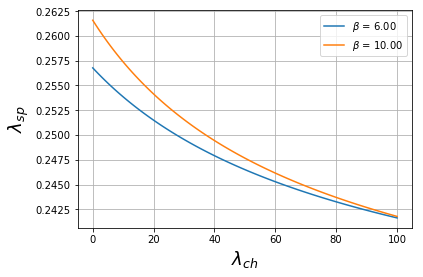

In [18]:
plt.plot(lambda_ch_range, lambda_sp6, "-", label=r"$\beta$ = 6.00")
plt.plot(lambda_ch_range, lambda_sp10, "-", label=r"$\beta$ = 10.00")
plt.xlabel(r"$\lambda_{ch}$", fontsize=18)
plt.ylabel(r"$\lambda_{sp}$", fontsize=18)
plt.legend()
plt.grid()
plt.show()

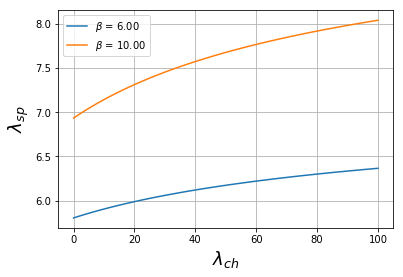

In [19]:
plt.plot(lambda_ch_range, maxChi_sp6, "-", label=r"$\beta$ = 6.00")
plt.plot(lambda_ch_range, maxChi_sp10, "-", label=r"$\beta$ = 10.00")
plt.xlabel(r"$\lambda_{ch}$", fontsize=18)
plt.ylabel(r"$\lambda_{sp}$", fontsize=18)
plt.legend()
plt.grid()
plt.show()

In [12]:
plt.plot(lambda_ch_range, maxChi_ch, "-")

NameError: name 'maxChi_ch' is not defined

In [ ]:
B = HDFArchive(input_file, "r")

In [ ]:
max_chi_sp = np.array([max(B["chi_sp_qW_-lambda_ch%.2f"%lam][:, Idx(0)].data.real) for lam in lambda_ch_range])

In [ ]:
plt.plot(lambda_ch_range, max_chi_sp, "--o")

In [20]:
total_income  = 2026
rent          = 755
brazil        = 60
gym           = 25
german_course = 200 

In [21]:
remain  = total_income - rent - brazil - gym - german_course

In [25]:
4 * 200 + 4 * 186 + 1500 + 1000 + 300 

4344

## __Determine the real and imaginary part of the self-energy extrapolated to the null value of the Matsubara fermionic frequency for each k-point__

#### In the following function, for each $\textbf{k}$ point the real and imaginary parts of the self-energy (it holds for any k-dependent correlation function) is extrapolated to 0 value of the fermionic Matsubara frequency. The function also __checks if the extrapolated value respects the causality ($Im \Sigma(\mathbf{k}, i\nu\rightarrow 0^{+} ) < 0$)__.

#### Here we use a linear fit with the first three positive fermionic Matsubara frequencies
#### $$Im \Sigma(\mathbf{k}, x) = A_{1}x + B_{1},$$
#### $$Re \Sigma(\mathbf{k}, x) = A_{2}x + B_{2},$$
#### and then we have 
#### $$Im \Sigma(\mathbf{k}, i\nu\rightarrow 0^{+} ) = Im \Sigma(\mathbf{k}, x = 0) = B_{1},$$
#### $$Re \Sigma(\mathbf{k}, i\nu\rightarrow 0^{+} ) = Re \Sigma(\mathbf{k}, x = 0) = B_{2}.$$


In [ ]:
def make_fit_lowfreq_kw(quantity, linear_fit=True):
    if linear_fit :
        causality = True
        def linear(x, a, b):
            return a + b * x
        ImQnt = []
        ReQnt = []
        n_pts = 3
        iw_vec = np.array([iw.value.real for iw in quantity.mesh[1] if iw.value.real >= 0.])
        iw_fit = np.array([iw_vec[j] for j in range(n_pts)])
        for q in quantity.mesh[0]:
            Qnt_w_fit = np.array([quantity[:, Idx(j)](q.value) for j in range(n_pts)])
            coef_re, coef_im = 0. ,0.
            cov_re, cov_im   = 0., 0.
            coef_re, cov_re = curve_fit(linear, iw_fit, Qnt_w_fit.real)
            coef_im, cov_im = curve_fit(linear, iw_fit, Qnt_w_fit.imag)
            ReQnt.append(coef_re)
            ImQnt.append(coef_im)
#            ReQnt.append(coef_re[0])
#            ImQnt.append(coef_im[0])
            if coef_im[0] > 0.:
                causality = False
    return np.array(ReQnt), np.array(ImQnt), causality

In [ ]:
# model parameters
U    = 10.0
nk   = 200
beta = 10.0

In [ ]:
input_sigma_DGammaA = "/home/deoliveira/Desktop/triangular_lattice/ladder_DGammaA/U%.1f/self_energy/DGammaA_self_energy-U%.2f-b%.2f-nk%s.h5"%(U, U, beta, nk)

In [ ]:
with HDFArchive(input_sigma_DGammaA, "r") as A:
    niwf          = A["Niwf_range"][0]
    Sigma_DGammaA = A["Sigma_DGA_tail_corrected-niwf%s"%niwf]

In [ ]:
ReSig0, ImSig0, causality = make_fit_lowfreq_kw(Sigma_DGammaA)

In [ ]:
print(f"The extrapolation of the ladder DΓA is causal ?  {causality}")

In [ ]:
ReSig0_extrap = np.array([sig[0] for sig in ReSig0])
ImSig0_extrap = np.array([sig[0] for sig in ImSig0])

In [ ]:
input_test = "/home/deoliveira/Desktop/triangular_lattice/ladder_DGammaA/U%.1f/GF_DGammaA/Gwk_DGammaA_DMFT-U%.2f-nk%s.h5"%(U, U, nk)

In [ ]:
with HDFArchive(input_test, "r") as A:
    ReSig0_input, ImSig0_input = A["Sig_LinExtrap-b%.2f"%beta]

In [ ]:
diff_Im = ImSig0_extrap - ImSig0_input
diff_Re = ReSig0_extrap - ReSig0_input

In [ ]:
for val in diff_Re:
    if val != 0.:
        print("!")

## __Finding the points over the FS__

The Fermi surface points are those which satisfy the quasi-particle equation (QPE)

$$\epsilon_{\mathbf{k}_{F}}^{(0)}-\mu-\text{Re}\Sigma\left(\mathbf{k}_{F},i\omega\rightarrow0\right)=0,$$

where $\epsilon_{\mathbf{k}_{F}}^{(0)}$ is the non-interacting dispersion relation, $\mu$ is the chemical potential and $\text{Re}\Sigma\left(\mathbf{k}_{F},i\omega\rightarrow0\right)$ is the real part of the self-energy extrapolated to the zeroth Matsubara function.

$\Rightarrow$ __In pratical terms__:

If we had the analytical expression for $\epsilon_{\mathbf{k}}^{(0)}$ and $\text{Re}\Sigma\left(\mathbf{k},i\omega\rightarrow0\right)$ the solution of the QPE would be reduced to a root finding problem. However as we do not have the analytical expression for $\text{Re}\Sigma\left(\mathbf{k},i\omega\rightarrow0\right)$ but a data set with the points representing this quantity and another data set representing $\epsilon_{\mathbf{k}}^{(0)}$, we compute the $F = \epsilon^{(0)}[j]-\mu-\text{Re}\Sigma\left(\omega\rightarrow0\right)[j]$ and we look for the values such that $F \leq \delta$, where $\delta$ represents the desired accuracy

For Brillouin zones (BZ) generated by __non-orthogonal vectors__ we use the __monkhorst (mkh) sampling method__ in which the set of points is genated in the plane (hyper-space) expanded by these non-orthogonal vectors. In order to obtain the set of points in the first BZ, we have to determine which points in this plane already lye in the first BZ, and for the each point outside this region, we have to trnaslate them into the 1st BZ through integers linear combinations in the non-orthogonal lattice vectors.

We first determine the __Fermi surface points__ in the __mkh grid__. As all the k-dependent quantites are produced with the same mkh grid we store the data indexes corresponding to the k vectors in overs the FS, in this way we know how to compute every quantity over the FS. 

In [ ]:
def make_idx_and_q_FS_pts(dispersion, Sigma_extrapolated, chem, q_vec, diff = 5E-2):
    QP_eq   = dispersion[:] + Sigma_extrapolated[:] - chem
    FS_idx  = np.array([i for i in range(len(QP_eq)) if abs(QP_eq[i]) <= diff])
    q_FS    = np.array([q_vec[j] for j in FS_idx])
    return FS_idx, q_FS

In [ ]:
input_GF_DGammaA = "/home/deoliveira/Desktop/triangular_lattice/ladder_DGammaA/U%.1f/GF_DGammaA/Gwk_DGammaA_DMFT-U%.2f-nk%s.h5"%(U, U, nk)

In [ ]:
with HDFArchive(input_GF_DGammaA, 'r') as A:
    mu_ldga    = A["mu_ldga_beta"]

In [ ]:
chem_ldga = mu_ldga[9]

In [ ]:
mu_ldga[9]

In [ ]:
input_dispersion = "/home/deoliveira/Desktop/triangular_lattice/dispersion/t1_tp1/dispersion-nk%s.h5"%nk

In [ ]:
with HDFArchive(input_dispersion, 'r') as A:
        dispersion =  A['dispersion'][0,0]

In [ ]:
q_vec = np.array([q.value for q in dispersion.mesh])

* Here we compute the Fermi surface points over the monkhorst sampling 

In [ ]:
idx_FS_mkh, q_FS_mkh = make_idx_and_q_FS_pts(dispersion.data.real, ReSig0_extrap, chem_ldga, q_vec)

In [ ]:
nk_FS = len(idx_FS_mkh)
print(f"There are {nk_FS} points over the Fermi surface for U = {U} and β = {beta}")

* Here we translate the points from the monkhorst sampling to the first Brillouin zone

In [ ]:
import itertools
import matplotlib.path as mplPath
def make_qBZ(q):

    # Vertices of the hexagonal BZ
    hex_verts = [(-2.*np.pi/3.,2.*np.pi/np.sqrt(3.)),
                 (2.*np.pi/3.,2.*np.pi/np.sqrt(3.)),
                 (4.*np.pi/3., 0.),
                 (2.*np.pi/3.,-2.*np.pi/np.sqrt(3.)),
                 (-2.*np.pi/3.,-2.*np.pi/np.sqrt(3.)),
                 (-4.*np.pi/3., 0.)
                ]

    # Creation of the BZ region
    hexPath = mplPath.Path(np.array(hex_verts))

    # Points lying inside BZ
    qx_in = []
    qy_in = []
    index_in = []

    # Points lying outside BZ
    qx_out = []
    qy_out = []
    index_out = []

    for j in range(len(q)):
        if hexPath.contains_point((q[j][0],q[j][1])) == True:
            qx_in.append(q[j][0])
            qy_in.append(q[j][1])
            index_in.append(j)

        else:
            qx_out.append(q[j][0])
            qy_out.append(q[j][1])
            index_out.append(j)

    # Reciprocal lattice translation vectors
    b1 = np.array((2.*np.pi, -2.*np.pi/np.sqrt(3.)))
    b2 = np.array((0., 4.*np.pi/np.sqrt(3.)))

    # Set of integer coefficients
    a1 = np.arange(-10, 11)
    a2 = np.arange(-10, 11)
    cartesian_product = list(itertools.product(a1, a2))

    # Translated points
    qx_new = []
    qy_new = []
    index_new = []

    for j in range(len(index_out)):

        vec_out = np.array((qx_out[j],qy_out[j]))

        for coeffs in cartesian_product:

            T = coeffs[0] * b1 + coeffs[1] * b2

            vec_T = vec_out + T

            if hexPath.contains_point((vec_T[0],vec_T[1])) == True:

                qx_new.append(vec_T[0])
                qy_new.append(vec_T[1])
                index_new.append(index_out[j])

                break

    qx_final = qx_in + qx_new
    qy_final = qy_in + qy_new
    index_BZ = index_in + index_new

    return np.asarray(qx_final), np.asarray(qy_final), np.asarray(index_BZ)


In [ ]:
qx_FS_BZ, qy_FS_BZ, idx_FS_BZ = make_qBZ(q=q_FS_mkh)

## __Parametrizing the circular Fermi surface__

* The natural way to represent each point (x$_{p}$, y$_{p}$) lying along the cirular Fermi surface is the the polar representation given by 

$$(x_{p}, y_{p}) = r(\sin(\theta_{p}), \cos(\theta_{p}) ),$$

where.

$$r = \sqrt{x_{p}^2 + y_{p}^2}$$

and $$\theta_{p} = \arctan\big(\frac{x_{p}}{y_{p}}\big).$$

* The data points stored in the q array are not ordered, which means that they are not clockwise or anti-clockwise stored in the array. In order to have a ordered representation of these points we have to ..    

In [ ]:
def make_radius_angle(xp, yp):
    r"""
    INPUTS:
    xp : array with the x-coordinates
    yp : array with the y-coordinates
    r"""
    distance_list = []
    angle_list    = []
    for j in range(len(xp)):  
        distance  = np.sqrt(xp[j]**2 + yp[j]**2)
        if (xp[j]>=0. and yp[j]>=0.):
            angle     = np.arctan(xp[j]/yp[j])
        elif (xp[j]>=0. and yp[j]<=0.) or (xp[j]<=0. and yp[j]<=0.):
            angle     = np.arctan(xp[j]/yp[j]) + np.pi
        else:
            angle     = np.arctan(xp[j]/yp[j]) + 2.*np.pi
            
        distance_list.append(distance)
        angle_list.append(angle)
        
        angle_ordered    = np.sort(np.asarray(angle_list))
        idx_ordered      = np.array([np.where(angle_list == val)[0][0] for val in angle_ordered])
        distance_ordered = np.array([distance_list[l] for l in idx_ordered])
        
    return distance_ordered, angle_ordered, idx_ordered

In [ ]:
R_FS, Ang_FS_param, idx_param = make_radius_angle(qx_FS_BZ, qy_FS_BZ)

In [ ]:
input_test = "/home/deoliveira/Desktop/triangular_lattice/ladder_DGammaA/U%.1f/GF_DGammaA/FS_qnts-U%.2f-nk%.2f.h5"%(U,U,nk)

In [ ]:
with HDFArchive(input_test, "r") as A:
    idx_param_test  = A["idx_parametr-b%.2f"%beta]    

* Once we have indexes of the points corresponding to the FS we can extract any quantity over the Fermi surface

### __Quantities over mkh $\Rightarrow$ Quantity over FS (mkh) $\Rightarrow$ Quantity over FS (BZ) $\Rightarrow$ Quantity over FS (BZ-clockwise)__

In [ ]:
# Parameters of the TRIQS GF iver the FS
units     = [(1,0)]
n_k       = nk_FS
iw_mesh   = Sigma_DGammaA.mesh[1]
BL        = BravaisLattice(units=units)
BZ        = BrillouinZone(BL)
k_mesh    = MeshBrillouinZone(BZ, n_k)
k_iw_mesh = MeshProduct(k_mesh, iw_mesh)    

In [ ]:
Sigma_FS_mkh =  Gf(mesh=k_iw_mesh, target_shape=[])

In [ ]:
for idx in range(nk_FS):
    Sigma_FS_mkh.data[idx, :] = Sigma_DGammaA.data[idx_FS_mkh[idx], :]

In [ ]:
Sigma_FS_BZ = Sigma_FS_mkh.copy()
Sigma_FS_BZ.zero()

In [ ]:
for idx in range(nk_FS):
    Sigma_FS_BZ.data[idx, :] = Sigma_FS_mkh.data[idx_FS_BZ[idx], :]

In [ ]:
Sigma_FS_BZ_param = Sigma_FS_mkh.copy()
Sigma_FS_BZ_param.zero()

In [ ]:
for idx in range(nk_FS):
    Sigma_FS_BZ_param.data[idx, :] = Sigma_FS_BZ.data[idx_param[idx], :]

In [ ]:
def make_closest_points(data, angles):
    arr         = data
    pts_data    = []
    for x in main_angles:
        # calculate the difference array
        difference_array = np.absolute(arr-x)
        # find the index of minimum element from the array
        index = difference_array.argmin()
        #print(index)
        pts_data.append(arr[index])
    return pts_data

In [ ]:
main_angles = [0., np.pi/2., np.pi/6.,  np.pi/3., 2.*np.pi/3., np.pi, 3.*np.pi/2., 2.*np.pi, 5.*np.pi/6.]

In [ ]:
main_angles_data = make_closest_points(Ang_FS_param, main_angles)

In [ ]:
plt.plot(Ang_FS_param, -Sigma_FS_BZ_param[:, Idx(0)].data.imag, "-*", label=r"$\beta$ = %.2f"%beta)

sticks = ["0", r"$\pi/2$",r"$\pi/6$", r"$\pi/3$",r"2$\pi/3$", r"$\pi$", r"$3\pi/2$", r"$2\pi$",r"5$\pi$/6"]
plt.xticks(main_angles_data, sticks, fontsize=14)
plt.grid()
plt.xlim(min(main_angles_data), max(main_angles_data))
plt.ylabel(r"-Im$\Sigma_{D\Gamma A}^{ladder}(\mathbf{k}_{F}, i\nu_{0} )$", fontsize=18)
plt.title(r"U = %.2f, $\beta$ = %.2f" %(U, beta), fontsize=18)
plt.xlim(0, np.pi)
#plt.savefig("/home/deoliveira/Desktop/triangular_lattice/plots/ImSig_iw0_over_FS-U%.2f-b%.2f.pdf"%(U,beta_range[j]), bbox_inches='tight')
plt.show()

In [ ]:
def make_quantity_over_FS(qnt_mkh, idx_FS_mkh, idx_FS_BZ, idx_param, static=False):
    units     = [(1,0)]
    n_k       = len(idx_FS_mkh)
    BL        = BravaisLattice(units=units)
    BZ        = BrillouinZone(BL)
    k_mesh    = MeshBrillouinZone(BZ, n_k)
    nk_range  = range(n_k)
    if static:
        Sigma_FS_mkh = Gf(mesh=k_mesh, target_shape=[])
        for idx in nk_range:
            Sigma_FS_mkh.data[idx] = qnt_mkh.data[idx_FS_mkh[idx]]

        Sigma_FS_BZ      = Sigma_FS_mkh.copy()
        Sigma_FS_BZ_sort = Sigma_FS_mkh.copy()
        Sigma_FS_BZ.zero()
        Sigma_FS_BZ_sort.zero()

        for idx in nk_range:
            Sigma_FS_BZ.data[idx] = Sigma_FS_mkh.data[idx_FS_BZ[idx]]
        for idx in nk_range:
            Sigma_FS_BZ_sort.data[idx] = Sigma_FS_BZ.data[idx_param[idx]]
        return Sigma_FS_BZ_sort
    else:    
        iw_mesh      = Sigma_DGammaA.mesh[1]
        k_iw_mesh    = MeshProduct(k_mesh, iw_mesh)
        Sigma_FS_mkh = Gf(mesh=k_iw_mesh, target_shape=[])

        for idx in nk_range:
            Sigma_FS_mkh.data[idx, :] = qnt_mkh.data[idx_FS_mkh[idx], :]

        Sigma_FS_BZ      = Sigma_FS_mkh.copy()
        Sigma_FS_BZ_sort = Sigma_FS_mkh.copy()
        Sigma_FS_BZ.zero()
        Sigma_FS_BZ_sort.zero()

        for idx in nk_range:
            Sigma_FS_BZ.data[idx, :] = Sigma_FS_mkh.data[idx_FS_BZ[idx], :]
            
        for idx in nk_range:
            Sigma_FS_BZ_sort.data[idx, :] = Sigma_FS_BZ.data[idx_param[idx], :]
        return Sigma_FS_BZ_sort

In [ ]:
Sigma_FS_BZ_func = make_quantity_over_FS(qnt_mkh=Sigma_DGammaA, idx_FS_mkh=idx_FS_mkh, idx_FS_BZ=idx_FS_BZ, idx_param=idx_param, static=False)

In [ ]:
plt.plot(Ang_FS_param, -Sigma_FS_BZ_param[:, Idx(0)].data.imag, "-o", label=r"$\beta$ = %.2f"%beta)
plt.plot(Ang_FS_param, -Sigma_FS_BZ_func[:, Idx(0)].data.imag, "-*", label=r"$\beta$ = %.2f"%beta)

sticks = ["0", r"$\pi/2$",r"$\pi/6$", r"$\pi/3$",r"2$\pi/3$", r"$\pi$", r"$3\pi/2$", r"$2\pi$",r"5$\pi$/6"]
plt.xticks(main_angles_data, sticks, fontsize=14)
plt.grid()
plt.xlim(min(main_angles_data), max(main_angles_data))
plt.ylabel(r"-Im$\Sigma_{D\Gamma A}^{ladder}(\mathbf{k}_{F}, i\nu_{0} )$", fontsize=18)
plt.title(r"U = %.2f, $\beta$ = %.2f" %(U, beta), fontsize=18)
plt.xlim(0, np.pi)
#plt.savefig("/home/deoliveira/Desktop/triangular_lattice/plots/ImSig_iw0_over_FS-U%.2f-b%.2f.pdf"%(U,beta_range[j]), bbox_inches='tight')
plt.show()

In [ ]:
U  = 10.0
nk = 200

In [ ]:
input_FS = "/home/deoliveira/Desktop/triangular_lattice/ladder_DGammaA/U%.1f/GF_DGammaA/FS_qnts-U%.2f-nk%.2f.h5"%(U,U,nk)

In [ ]:
beta = 10
with HDFArchive(input_FS, "r") as A:
        SigDGA_input   = A["Sig_DGammaA_FS-b%.2f"%beta]
        G_DGA_input    = A["G_DGammaA_FS-b%.2f"%beta]    
        ReSig0, ImSig0 = A["Sig0_DGammaA_FS-b%.2f"%beta] 
        ReG0, ImG0     = A["G0_DGammaA_FS-b%.2f"%beta] 
        Ang_input      = A["angle_FS-b%.2f"%beta]


In [ ]:
sticks = ["0",r"$\pi/6$", r"$\pi/3$"]#, r"$\pi/2$", r"2$\pi/3$", r"$\pi$", r"$3\pi/2$", r"$2\pi$",r"5$\pi$/6"]
main_angles = [0., np.pi/6.,  np.pi/3.]#, np.pi/2., 2.*np.pi/3., np.pi, 3.*np.pi/2., 2.*np.pi, 5.*np.pi/6.]

In [ ]:
main_angles_input = make_closest_points(Ang_input, main_angles)

In [ ]:
#plt.plot(Ang_FS_param, -Sigma_FS_BZ_param[:, Idx(0)].data.imag, "-o", label=r"$\beta$ = %.2f"%beta)
#plt.plot(Ang_FS_param, -Sigma_FS_BZ_func[:, Idx(0)].data.imag, "-v", label=r"$\beta$ = %.2f"%beta)
plt.plot(Ang_input, -SigDGA_input[:, Idx(0)].data.imag, "-*", label=r"at i$\omega_{0}$")
plt.plot(Ang_input, -ImSig0.data[:].real, "-o", label=r"for i$\omega_{n} \rightarrow 0$")
plt.xticks(main_angles_input, sticks, fontsize=14)
plt.grid()
plt.xlim(min(main_angles_input), max(main_angles_input))
plt.ylabel(r"-Im$\Sigma_{D\Gamma A}^{ladder}(\mathbf{k}_{F})$", fontsize=18)
plt.title(r"U = %.2f, $\beta$ = %.2f" %(U, beta), fontsize=18)
plt.xlim(0, np.pi/3)
plt.legend()
#plt.savefig("/home/deoliveira/Desktop/triangular_lattice/plots/ImSig_iw0_over_FS-U%.2f-b%.2f.pdf"%(U,beta_range[j]), bbox_inches='tight')
plt.show()

In [ ]:
plt.plot(Ang_input, -ImSig0.data[:].real, "-o", label=r"$\beta$ = %.2f"%beta)
plt.xticks(main_angles_input, sticks, fontsize=14)
plt.grid()
plt.xlim(min(main_angles_input), max(main_angles_input))
plt.ylabel(r"-Im$\Sigma_{D\Gamma A}^{ladder}(\mathbf{k}_{F}, i\omega_{n} \rightarrow 0 )$", fontsize=18)
plt.title(r"U = %.2f, $\beta$ = %.2f" %(U, beta), fontsize=18)
plt.xlim(0, np.pi/3)
#plt.savefig("/home/deoliveira/Desktop/triangular_lattice/plots/ImSig_iw0_over_FS-U%.2f-b%.2f.pdf"%(U,beta_range[j]), bbox_inches='tight')
plt.show()

In [ ]:
plt.plot(Ang_input, -SigDGA_input[:, Idx(0)].data.imag, "-*", label=r"$\beta$ = %.2f"%beta)
plt.xticks(main_angles_input, sticks, fontsize=14)
plt.grid()
plt.xlim(min(main_angles_input), max(main_angles_input))
plt.ylabel(r"-Im$\Sigma_{D\Gamma A}^{ladder}(\mathbf{k}_{F}, i\omega_{0} )$", fontsize=18)
plt.title(r"U = %.2f, $\beta$ = %.2f" %(U, beta), fontsize=18)
plt.xlim(0, np.pi/3)
#plt.savefig("/home/deoliveira/Desktop/triangular_lattice/plots/ImSig_iw0_over_FS-U%.2f-b%.2f.pdf"%(U,beta_range[j]), bbox_inches='tight')
plt.show()

In [ ]:
plt.plot(Ang_input, np.round(-ImG0.data.real[:],3)/np.pi, "-o", label=r"$\beta$ = %.2f"%beta)
plt.xticks(main_angles_input, sticks, fontsize=14)
plt.grid()
plt.xlim(min(main_angles_input), max(main_angles_input))
plt.ylabel(r"$A_{D\Gamma A}^{ladder}(\mathbf{k}_{F}, i\omega_{n} \rightarrow 0 )$", fontsize=18)
plt.title(r"U = %.2f, $\beta$ = %.2f" %(U, beta), fontsize=18)
plt.xlim(0, np.pi/3)
#plt.savefig("/home/deoliveira/Desktop/triangular_lattice/plots/ImSig_iw0_over_FS-U%.2f-b%.2f.pdf"%(U,beta_range[j]), bbox_inches='tight')
plt.show()

In [ ]:
plt.plot(Ang_input, -G_DGA_input[:, Idx(0)].data.imag/np.pi, "-o", label=r"$\beta$ = %.2f"%beta)
plt.xticks(main_angles_input, sticks, fontsize=14)
plt.grid()
plt.xlim(min(main_angles_input), max(main_angles_input))
plt.ylabel(r"-$\frac{1}{\pi}$Im G$_{D\Gamma A}^{ladder}(\mathbf{k}_{F}, i\omega_{0})$", fontsize=18)
plt.title(r"U = %.2f, $\beta$ = %.2f" %(U, beta), fontsize=18)
plt.xlim(0, np.pi/3)
#plt.savefig("/home/deoliveira/Desktop/triangular_lattice/plots/ImSig_iw0_over_FS-U%.2f-b%.2f.pdf"%(U,beta_range[j]), bbox_inches='tight')
plt.show()

In [ ]:
plt.plot(Ang_input, -ImG0.data.real[:]/np.pi, "o", label=r"for i$\omega_{n} \rightarrow 0$")
plt.plot(Ang_input, -G_DGA_input[:, Idx(0)].data.imag/np.pi, "-*", label=r"at i$\omega_{0}$")

plt.xticks(main_angles_input, sticks, fontsize=14)
plt.grid()
plt.xlim(min(main_angles_input), max(main_angles_input))
plt.ylabel(r"-$\frac{1}{\pi}$Im G$_{D\Gamma A}^{ladder}(\mathbf{k}_{F})$", fontsize=18)
plt.title(r"U = %.2f, $\beta$ = %.2f" %(U, beta), fontsize=18)
plt.xlim(0, np.pi/3)
plt.legend()
#plt.savefig("/home/deoliveira/Desktop/triangular_lattice/plots/ImSig_iw0_over_FS-U%.2f-b%.2f.pdf"%(U,beta_range[j]), bbox_inches='tight')
plt.show()

In [ ]:
idx_period = np.where(Ang_input == main_angles_input[2])[0][0]

In [ ]:
qnt_period = np.array([ImG0.data.real[j] for j in range(idx_period)])
ang_period = np.array([Ang_input[j] for j in range(idx_period)])

In [ ]:
plt.plot(ang_period, -qnt_period/np.pi, "o", label=r"for i$\omega_{n} \rightarrow 0$")
#plt.plot(Ang_input, -G_DGA_input[:, Idx(0)].data.imag/np.pi, "-*", label=r"at i$\omega_{0}$")

plt.xticks(main_angles_input, sticks, fontsize=14)
plt.grid()
plt.xlim(min(main_angles_input), max(main_angles_input))
plt.ylabel(r"-$\frac{1}{\pi}$Im G$_{D\Gamma A}^{ladder}(\mathbf{k}_{F}, i\omega_{0})$", fontsize=18)
plt.title(r"U = %.2f, $\beta$ = %.2f" %(U, beta), fontsize=18)
#plt.xlim(0, np.pi/12)
plt.legend()
#plt.savefig("/home/deoliveira/Desktop/triangular_lattice/plots/ImSig_iw0_over_FS-U%.2f-b%.2f.pdf"%(U,beta_range[j]), bbox_inches='tight')
plt.show()

In [ ]:
input_ana_cont = "/home/deoliveira/Desktop/triangular_lattice/ladder_DGammaA/U%.1f/GF_DGammaA/G_FS_ReW-U%.2f-nk%.2f.h5"%(U,U,nk)

In [ ]:
with HDFArchive(input_ana_cont, "r") as A:
    A_Bryan = A["A_Bryan-b%.2f"%beta]
    A_Chi2  = A["A_Chi2Curv-b%.2f"%beta]
    A_Clas  = A["A_Classic-b%.2f"%beta] 
    A_linF  = A["A_LinFit-b%.2f"%beta]

In [ ]:
input2 =  "/home/deoliveira/Desktop/triangular_lattice/ladder_DGammaA/U%.1f/GF_DGammaA/G_FS_ReW-U%.2f-nk%.2f_more_npoints.h5"%(U,U,nk)

In [ ]:
with HDFArchive(input2, "r") as A:
    A_Bryan2 = A["A_Bryan-b%.2f"%beta]
    A_Chi22  = A["A_Chi2Curv-b%.2f"%beta]
    A_Clas2  = A["A_Classic-b%.2f"%beta] 
    A_linF2  = A["A_LinFit-b%.2f"%beta]

In [ ]:
NK = len(A_Clas.mesh[0])
A_class_data = np.array([A_Clas[Idx(idx,0,0),:](0).real for idx in range(NK)])
A_class_data2 = np.array([A_Clas2[Idx(idx,0,0),:](0).real for idx in range(NK)])

A_Bryan_data = np.array([A_Bryan[Idx(idx,0,0),:](0).real for idx in range(NK)])
A_Bryan_data2 = np.array([A_Bryan2[Idx(idx,0,0),:](0).real for idx in range(NK)])

A_chi2_data = np.array([A_Chi2[Idx(idx,0,0),:](0).real for idx in range(NK)])
A_chi2_data2 = np.array([A_Chi22[Idx(idx,0,0),:](0).real for idx in range(NK)])

A_linF_data = np.array([A_linF[Idx(idx,0,0),:](0).real for idx in range(NK)])
A_linF_data2 = np.array([A_linF2[Idx(idx,0,0),:](0).real for idx in range(NK)])

In [ ]:
w_max = .5
w_min = -.5
oplotr(A_Bryan2[Idx(0,0,0),:], "-*", x_window=(w_min,w_max), label=r"$\theta_{FS}$ = 0")
oplotr(A_Bryan2[Idx(34,0,0),:], "-o", x_window=(w_min,w_max), label=r"$\theta_{FS} = \pi$/6")
plt.xlabel(r"$\omega$", fontsize=18)
plt.ylabel(r"A$(\theta_{FK},\omega$)", fontsize=18)
plt.grid()

In [ ]:
w_max = .5
w_min = -.5

oplotr(A_Clas2[Idx(0,0,0),:], "-s", x_window=(w_min,w_max), label=r"Classical")
oplotr(A_Bryan2[Idx(0,0,0),:], "o", x_window=(w_min,w_max), label=r"Bryan")
oplotr(A_Chi22[Idx(0,0,0),:], "v", x_window=(w_min,w_max), label=r"$\chi2$")
oplotr(A_linF2[Idx(0,0,0),:], "*", x_window=(w_min,w_max), label=r"Linear fit")

plt.xlabel(r"$\omega$", fontsize=18)
plt.ylabel(r"A$(\theta_{FK} = 0,\omega$)", fontsize=18)
plt.grid()

In [ ]:
w_max = .5
w_min = -.5

oplotr(A_Clas2[Idx(34,0,0),:], "-s", x_window=(w_min,w_max), label=r"Classical")
oplotr(A_Bryan2[Idx(34,0,0),:], "o", x_window=(w_min,w_max), label=r"Bryan")
oplotr(A_Chi22[Idx(34,0,0),:], "v", x_window=(w_min,w_max), label=r"$\chi2$")
oplotr(A_linF2[Idx(34,0,0),:], "*", x_window=(w_min,w_max), label=r"Linear fit")

plt.xlabel(r"$\omega$", fontsize=18)
plt.ylabel(r"A$(\theta_{FK} = \pi/6,\omega$)", fontsize=18)
plt.grid()

In [ ]:
nw_ = len(A_Bryan.mesh[1])//2

In [ ]:
plt.plot(ang_period, A_class_data2, "-s", label=r"Classical")
plt.plot(ang_period, A_Bryan_data2, "-o", label=r"Bryan")
plt.plot(ang_period, A_chi2_data2, "-*", label=r"$\chi$2")
plt.plot(ang_period, A_linF_data2, "-*", label=r"Linear Fit")

plt.xticks(main_angles_input, sticks, fontsize=14)
plt.grid()
plt.xlim(min(main_angles_input), max(main_angles_input))
#plt.ylabel(r"-$\frac{1}{\pi}$Im G$_{D\Gamma A}^{ladder}(\mathbf{k}_{F}, i\omega_{0})$", fontsize=18)
plt.title(r"U = %.2f, $\beta$ = %.2f" %(U, beta), fontsize=18)
#plt.xlim(0, np.pi/9)
plt.legend()
#plt.savefig("/home/deoliveira/Desktop/triangular_lattice/plots/ImSig_iw0_over_FS-U%.2f-b%.2f.pdf"%(U,beta_range[j]), bbox_inches='tight')
plt.show()

In [ ]:
w_max = 1
w_min = -1
oplotr(A_Clas[Idx(0,0,0),:], "-*", x_window=(w_min,w_max))
#oplotr(A_Clas[Idx(10,0,0),:], "-", x_window=(-2.5,2.5))
oplotr(A_Clas[Idx(34,0,0),:], "-.", x_window=(w_min,w_max))
plt.grid()

## __Anal. cont.__

In [ ]:
G_KF = G_DGA_input[Idx(0,0,0),:]

In [ ]:
G_KF_rank2 = Gf(mesh=G_KF.mesh, target_shape = [1, 1])

In [ ]:
G_KF_rank2[0,0].data[:] = G_KF.data[:]

In [ ]:
n_tau = 2*len(G_KF.mesh) + 1
print(f"Number of tau points = {n_tau}")

In [ ]:
G_tau = GfImTime(beta=G_KF.mesh.beta, indices=[0], n_points=n_tau)

In [ ]:
G_tau

In [ ]:
G_tau.set_from_fourier(G_KF_rank2)

In [ ]:
oplot(G_tau)

In [ ]:
from triqs_maxent import *
#HyperbolicOmegaMesh
tm = TauMaxEnt(cost_function='bryan', probability='normal')
tm.omega = LinearOmegaMesh(omega_min=-10, omega_max=10, n_points=1000)
tm.alpha_mesh = LogAlphaMesh(alpha_min=1e-4, alpha_max=100, n_points=100)
tm.set_G_tau(G_tau)
tm.set_error(1.e-3)
result = tm.run()

In [ ]:
res=result
plt.plot(res.omega, res.analyzer_results['LineFitAnalyzer']['A_out'],'-', lw=3, label='LineFit')
plt.plot(res.omega, res.analyzer_results['Chi2CurvatureAnalyzer']['A_out'],'-', lw=3, label='Chi2Curvature')
plt.plot(res.omega, res.analyzer_results['BryanAnalyzer']['A_out'], '-', lw=3, label='Bryan')
plt.plot(res.omega, res.analyzer_results['ClassicAnalyzer']['A_out'],'-', lw=3, label='Classic')
plt.grid()
plt.xlim(-0.5,0.5)
plt.legend()

In [ ]:
iw_mesh   = MeshReFreq(omega_min=-10, omega_max=10, n_max=1000)

In [ ]:
A_kw   = Gf(mesh=iw_mesh, target_shape=[])

In [ ]:
A_kw.data[:] = res.analyzer_results['BryanAnalyzer']['A_out'][:]

In [ ]:
plt.plot(res.omega, res.analyzer_results['BryanAnalyzer']['A_out'], '-', lw=3, label='Bryan')
oplotr(A_kw)

In [ ]:
A_kw(0).real

In [ ]:
idx_period = np.where(Ang_input == main_angles_input[2])[0][0]

## __Trilex vertex over the Fermi surface__

In [ ]:
U    = 10.0
beta = 5.0
nk   = 200

In [ ]:
input_sigma_DGammaA = "/home/deoliveira/Desktop/triangular_lattice/ladder_DGammaA/U%.1f/self_energy/DGammaA_self_energy-U%.2f-b%.2f-nk%s.h5"%(U, U, beta, nk)

In [ ]:
with HDFArchive(input_sigma_DGammaA, "r") as A:
    niwf          = A["Niwf_range"][0]

In [ ]:
input_BSE   = "/home/deoliveira/Desktop/triangular_lattice/ladder_DGammaA/U%.1f/lattice_suscep_BSE/nk%s/lattice_suscep_U%.2f-b%.2f-nk%s.h5"%(U, nk, U, beta, nk)

In [ ]:
with HDFArchive(input_BSE, "r") as A:                                                                     
    trilex_ch = A["trilex_ch_Wnq-niwf%s"%niwf]                                                       
    trilex_sp = A["trilex_sp_Wnq-niwf%s"%niwf]

In [ ]:
trilex_ch

In [ ]:
beta = 5.0

In [ ]:
input_SigFS = "/home/deoliveira/Desktop/triangular_lattice/ladder_DGammaA/U%.1f/self_energy/SigDGammaA_over_FS-U%.2f-nk%s.h5"%(U, U, nk)

In [ ]:
with HDFArchive(input_SigFS, "a") as A:
    FS_idx_mkh   = A["FS_Idx_mkh-b%.2f"%beta]           
    q_FS_mkh     = A["qFS_mkh-b%.2f"%beta]              


In [ ]:
qx_FS_BZ, qy_FS_BZ, idx_FS_BZ = make_qBZ(q=q_FS_mkh)

In [ ]:
units        = [(1,0)]
n_k          = len(idx_FS_BZ)

iw_mesh_ch   = trilex_ch.mesh[0]
in_mesh_ch   = trilex_ch.mesh[1]
iw_mesh_sp   = trilex_sp.mesh[0]
in_mesh_sp   = trilex_sp.mesh[1]

BL        = BravaisLattice(units=units)
BZ        = BrillouinZone(BL)
k_mesh    = MeshBrillouinZone(BZ, n_k)

iw_in_k_mesh_ch = MeshProduct(iw_mesh_ch, in_mesh_ch, k_mesh)    
iw_in_k_mesh_sp = MeshProduct(iw_mesh_sp, in_mesh_sp, k_mesh)    


In [ ]:
Trilex_ch_FS_mkh =  Gf(mesh=iw_in_k_mesh_ch, target_shape=[])
Trilex_sp_FS_mkh =  Gf(mesh=iw_in_k_mesh_sp, target_shape=[])

In [ ]:
for idx in range(n_k):
    Trilex_ch_FS_mkh.data[:, :, idx] = trilex_ch[0,0,0,0].data[:, :, FS_idx_mkh[idx]]
    Trilex_sp_FS_mkh.data[:, :, idx] = trilex_sp[0,0,0,0].data[:, :, FS_idx_mkh[idx]]

In [ ]:
Trilex_ch_FS_BZ =  Trilex_ch_FS_mkh.copy()
Trilex_sp_FS_BZ =  Trilex_sp_FS_mkh.copy()
Trilex_ch_FS_BZ.zero()
Trilex_sp_FS_BZ.zero()

In [ ]:
for idx in range(n_k):
    Trilex_ch_FS_BZ.data[:, :, idx] = Trilex_ch_FS_mkh.data[:, :, idx_FS_BZ[idx]]
    Trilex_sp_FS_BZ.data[:, :, idx] = Trilex_sp_FS_mkh.data[:, :, idx_FS_BZ[idx]]

In [ ]:
R_FS, Ang_FS_param, idx_param = make_radius_angle(qx_FS_BZ, qy_FS_BZ)

In [ ]:
Trilex_ch_FS_BZ_ord = Trilex_ch_FS_BZ.copy() 
Trilex_sp_FS_BZ_ord = Trilex_sp_FS_BZ.copy()
Trilex_ch_FS_BZ_ord.zero()
Trilex_sp_FS_BZ_ord.zero()

In [ ]:
for idx in range(n_k):
    Trilex_ch_FS_BZ_ord.data[:, :, idx] = Trilex_ch_FS_BZ.data[:, :, idx_param[idx]]
    Trilex_sp_FS_BZ_ord.data[:, :, idx] = Trilex_sp_FS_BZ.data[:, :, idx_param[idx]]

In [ ]:
main_angles = [0., np.pi/2., np.pi/6.,  np.pi/3., 2.*np.pi/3., np.pi, 3.*np.pi/2., 2.*np.pi, 5.*np.pi/6.]
main_angles_beta = []
arr         = Ang_FS_param
pts_data    = []
for x in main_angles:
    # calculate the difference array
    difference_array = np.absolute(arr-x)
    # find the index of minimum element from the array
    index = difference_array.argmin()
    pts_data.append(arr[index])
main_angles_beta.append(pts_data)

In [ ]:
j=4
plt.plot(Ang_FS_param,Trilex_sp_FS_BZ_ord[Idx(0), Idx(10), :].data.imag, "--*", label=r"$\beta$ = %.2f"%beta)

sticks = ["0", r"$\pi/2$",r"$\pi/6$", r"$\pi/3$",r"2$\pi/3$", r"$\pi$", r"$3\pi/2$", r"$2\pi$",r"5$\pi$/6"]
plt.xticks(main_angles_beta[0], sticks, fontsize=14)
plt.grid()
plt.xlim(min(pts_data), max(pts_data))
plt.ylabel(r"-Im$\Sigma_{D\Gamma A}^{ladder}(\mathbf{k}_{F}, i\nu_{0} )$", fontsize=18)
plt.title(r"U = %.2f, $\beta$ = %.2f" %(U, beta), fontsize=18)
#plt.xlim(0, np.pi)
#plt.savefig("/home/deoliveira/Desktop/triangular_lattice/plots/ImSig_iw0_over_FS-U%.2f-b%.2f.pdf"%(U,beta_range[j]), bbox_inches='tight')
plt.show()

In [ ]:
TrilexVertez_avg_Fs     = []
Sigma_avg_FS = []
for beta in beta_range:
    with HDFArchive(input_SigFS, "a") as A:
        Sigma_FS_mkh = A["Sigma_DGammaA_FS_mkh-b%.2f"%beta]
        #Sigma_avg_FS.append(A["Sigma_DGammaA_avg-b%.2f"%beta])     
        FS_idx_mkh   = A["FS_Idx_mkh-b%.2f"%beta]           
        q_FS_mkh     = A["qFS_mkh-b%.2f"%beta]              
    with HDFArchive(input_G_FS, "a") as A:
        G_FS_mkh = A["G_DGammaA_FS_mkh-b%.2f"%beta]  
        #G_avg_FS.append(A["G_DGammaA_avg-b%.2f"%beta])
    # Translating the MKH points into the 1st BZ    
    qx_FS_BZ, qy_FS_BZ, idx_FS_BZ = make_qBZ(q=q_FS_mkh)
    units = [(1,0)]
    n_k   = len(idx_FS_BZ)
    iw_mesh   = Sigma_FS_mkh.mesh[1]
    BL        = BravaisLattice(units=units)
    BZ        = BrillouinZone(BL)
    k_mesh    = MeshBrillouinZone(BZ, n_k)
    k_iw_mesh = MeshProduct(k_mesh, iw_mesh)    
    
    Sigma_FS_BZ =  Gf(mesh=k_iw_mesh, target_shape=[])
    G_FS_BZ     =  Gf(mesh=k_iw_mesh, target_shape=[])
    
    for idx in range(n_k):
        Sigma_FS_BZ.data[idx, :] = Sigma_FS_mkh.data[idx_FS_BZ[idx], :]
        G_FS_BZ.data[idx, :]     = G_FS_mkh.data[idx_FS_BZ[idx],:]
    
    qx_FS_BZ, qy_FS_BZ, idx_FS_BZ = make_qBZ(q=q_FS_mkh)
    
    R_FS, Ang_FS_param, idx_param = make_radius_angle(qx_FS_BZ, qy_FS_BZ)
    
    Sigma_FS_BZ_ordered =  Gf(mesh=k_iw_mesh, target_shape=[])
    G_FS_BZ_ordered     =  Gf(mesh=k_iw_mesh, target_shape=[])
    
    for idx in range(n_k):
        Sigma_FS_BZ_ordered.data[idx, :] = Sigma_FS_BZ.data[idx_param[idx], :]
        G_FS_BZ_ordered.data[idx, :]     = G_FS_BZ.data[idx_param[idx], :]
    with HDFArchive(output_file, "a") as A:
        A["radius_FS-b%.2f"%beta] = R_FS
        A["angle_FS-b%.2f"%beta]  = Ang_FS_param
        A["idx_FS-b%.2f"%beta]    = idx_param
        A["Sigma_FS-b%.2f"%beta]  = Sigma_FS_BZ_ordered
        A["G_FS-b%.2f"%beta]      = G_FS_BZ_ordered